In [1]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(tidyverse))
set.seed(1234)

suppressMessages(library(data.table))
library(cowplot)
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [2]:
## Load links annotated by 1_Annotate_links_by_enhancers_geneHancerInter_filter_diffuse_DACRs.ipynb
all.links.tumor.normal <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/linkingGenes_v7.0/annotate.links/tumor_only_multiome/Pancan_all.links.filtered_by_zscore_diffused_links_annotated_by_GeneHancer_EpiMap_ENCODE_with_CNV_DAP_DEG_met.txt')



In [3]:
colors <- c(BRCA = "#fb9a99", BRCA_Basal = "#e31a1c",
             CESC = "#fdbf6f",
            'CESC_Non-squamous' = '#C69158',
            CRC = '#ff7f00',
            ccRCC = "#cab2d6", 
            GBM = "#6a3d9a" ,
            MM = "#b15928" ,
            HNSCC = "#b2df8a",
        OV = "#33a02c", 
            SKCM='#c9b92e',
        PDAC = "#a6cee3", 
            PDAC_Basal='#80A0AA',
        UCEC = "#1f78b4" )
colors.coverage <- c(BRCA = "#b06c6b", 
             CESC = "#b1864e",
            'CESC_Non-squamous' = '#C69158',
                     CRC = '#b35900',
            HNSCC = "#7d9c61",
        OV = "#24701f", 
        PDAC = "#74909f", 
        PDAC_Basal='#80A0AA',
        UCEC = "#16547e",
         SKCM='#B3B36B')

In [4]:
genes.gained <- all.links.tumor.normal %>% 
            filter(cnv=='Gain' & cnv.pct > 0.25 & N.cells.with.cnv > 2000) %>%
            mutate(gene.cancer = paste(gene, Cancer, sep ='_')) %>% 
            pull(gene.cancer) %>% 
            unique


In [7]:
combo.pancan.aver.Piece.normal <- readRDS('/diskmnt/Projects/snATAC_primary/PanCan_ATAC_data_freeze/v7.0/Multiome/Averaged/Averaged_by_Cancer_Piece_cell_type.normal_all_cells_multiome_obj.20230306.rds')



# PDAC heatmap

In [8]:
cancer.type = 'PDAC'
features <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) %>%
    dplyr::select(Cancer, peak, gene, ends_with('Annotation')) %>%
    distinct()  
dim(features)
head(features)

[1] 147   6

Cancer,peak,gene,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PDAC,chr4-8127462-8127962,ABLIM2,,,PLS
PDAC,chr4-8128064-8128564,ABLIM2,,Enhancer,"pELS,CTCF-bound"
PDAC,chr9-133252254-133252754,ABO,Enhancer,Enhancer,"dELS,CTCF-bound"
PDAC,chr17-81119470-81119970,ACTG1,Promoter/Enhancer,Promoter,"dELS,CTCF-bound"
PDAC,chr17-81912630-81913130,ACTG1,,Enhancer,"pELS,CTCF-bound"
PDAC,chr14-68695280-68695780,ACTN1,,Enhancer,"pELS,CTCF-bound"


In [9]:
#Table S3 PDAC tab
tosave <- (all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type))
fwrite(tosave, 
     glue::glue('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Suppl.tables/resubmission/Links_{cancer.type}_figure3d.tsv'), sep='\t')





In [10]:
row.anno <- features %>%
    dplyr::select(-gene) %>%
    filter(!duplicated(peak)) %>% 
    data.frame(row.names = 'peak')

head(row.anno[features$peak,])

,Cancer,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
,<chr>,<chr>,<chr>,<chr>
chr4-8127462-8127962,PDAC,,,PLS
chr4-8128064-8128564,PDAC,,Enhancer,"pELS,CTCF-bound"
chr9-133252254-133252754,PDAC,Enhancer,Enhancer,"dELS,CTCF-bound"
chr17-81119470-81119970,PDAC,Promoter/Enhancer,Promoter,"dELS,CTCF-bound"
chr17-81912630-81913130,PDAC,,Enhancer,"pELS,CTCF-bound"
chr14-68695280-68695780,PDAC,,Enhancer,"pELS,CTCF-bound"


In [11]:
#Fetch ATAC and RNA expression data from the averaged object
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'pancan'
toplot.atac <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$peak), slot = 'scale.data')
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'SCT'
toplot.rna <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$gene), slot = 'scale.data')

toplot.atac <- toplot.atac[,features$peak] %>% t
toplot.rna <- toplot.rna[,features$gene] %>% t

toplot.atac <- toplot.atac[,!grepl('oublet', colnames(toplot.atac))]
toplot.rna <- toplot.rna[,!grepl('oublet', colnames(toplot.rna))]

dim(toplot.rna)

meta <- combo.pancan.aver.Piece.normal@meta.data %>% filter(!grepl('oublet', rownames(.)))
meta <- meta %>% filter(Cancer == cancer.type & (Sample_type2=='Primary' | is.na(Sample_type2)))
toplot.atac <- toplot.atac[,rownames(meta)]
toplot.rna <- toplot.rna[,rownames(meta)]



[1] 147 142

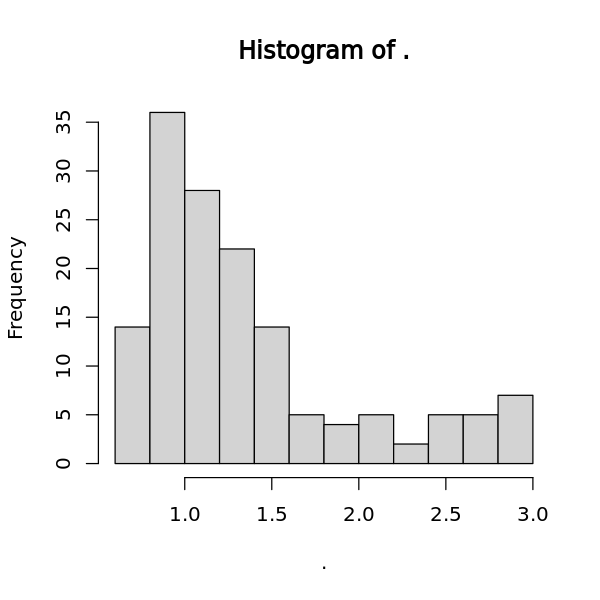

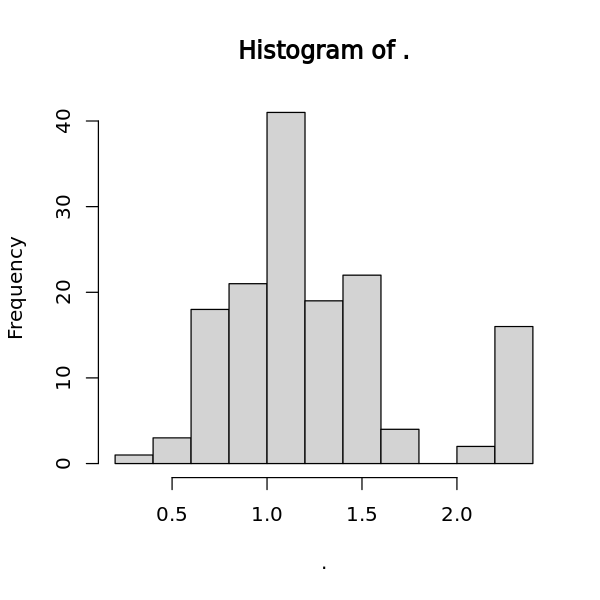

In [14]:

atac.sd <- sapply(rownames(toplot.atac), function(x){
    sd(t(toplot.atac[, grepl('Tumor', colnames(toplot.atac))])[,x])
})

rna.sd <- sapply(rownames(toplot.rna), function(x){
    sd(t(toplot.rna[, grepl('Tumor', colnames(toplot.rna))])[,x])
}) 

options(repr.plot.width=5, repr.plot.height=5)

atac.sd %>% hist
rna.sd %>% hist

if(cancer.type %in% c('PDAC')) {
    toplot.atac <- toplot.atac[atac.sd<2 & rna.sd<1.9,]
    toplot.rna <- toplot.rna[atac.sd<2 & rna.sd<1.9,]

}

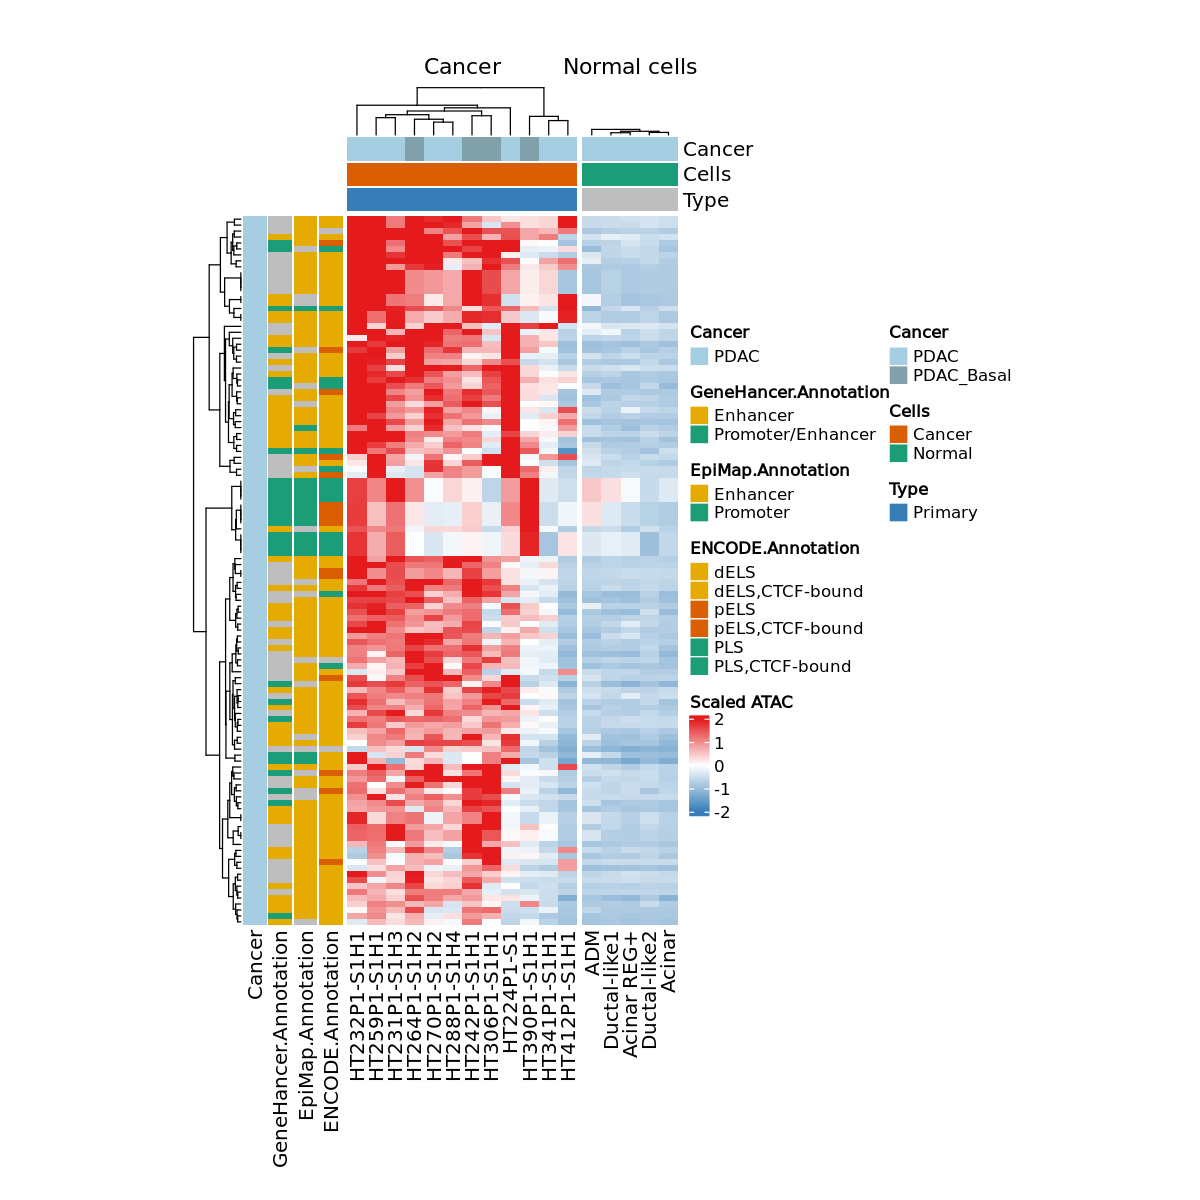

In [15]:
breaks = seq(-2 ,2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(c( '#377eb8','white','#e41a1c'))(length(breaks)))

column_ha = HeatmapAnnotation(Cancer = meta$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.atac)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                              Type = meta$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)

row_ha = rowAnnotation(df = row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , ],
                      col = list(Cancer = colors,
                          GeneHancer.Annotation = c('Promoter/Enhancer' = '#1b9e77',
                                                           'Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                EpiMap.Annotation = c('Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                ENCODE.Annotation = c('PLS' = '#1b9e77',
                                                      'PLS,CTCF-bound' = '#1b9e77',
                                                      'dELS' = '#e6ab02',
                                                      'dELS,CTCF-bound' = '#e6ab02',
                                                      'pELS' = '#d95f02',
                                                      'pELS,CTCF-bound' = '#d95f02',
                                                     'CTCF-only,CTCF-bound' = '#7570b3',
                                                     'DNase-H3K4me3' = '#a6761d',
                                                     'DNase-H3K4me3,CTCF-bound' = '#a6761d')
                                )
                      )


col.split <- case_when(is.na(meta$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

#row.split <- row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , 'Cancer']

colnames(toplot.atac) <- str_split_fixed(colnames(toplot.atac), '__', 5)[,3]

options(repr.plot.width=10, repr.plot.height=10)
p <- Heatmap(toplot.atac, name = "Scaled ATAC", cluster_column_slices = F,
             col = color.palette,cluster_rows = T, show_row_names = F,
             show_column_names = T, 
             top_annotation = column_ha,
             left_annotation = row_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
            column_split = col.split, 
             #row_split = row.split,
             width = unit(7, "cm"), height = unit(15, "cm"))

p



Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


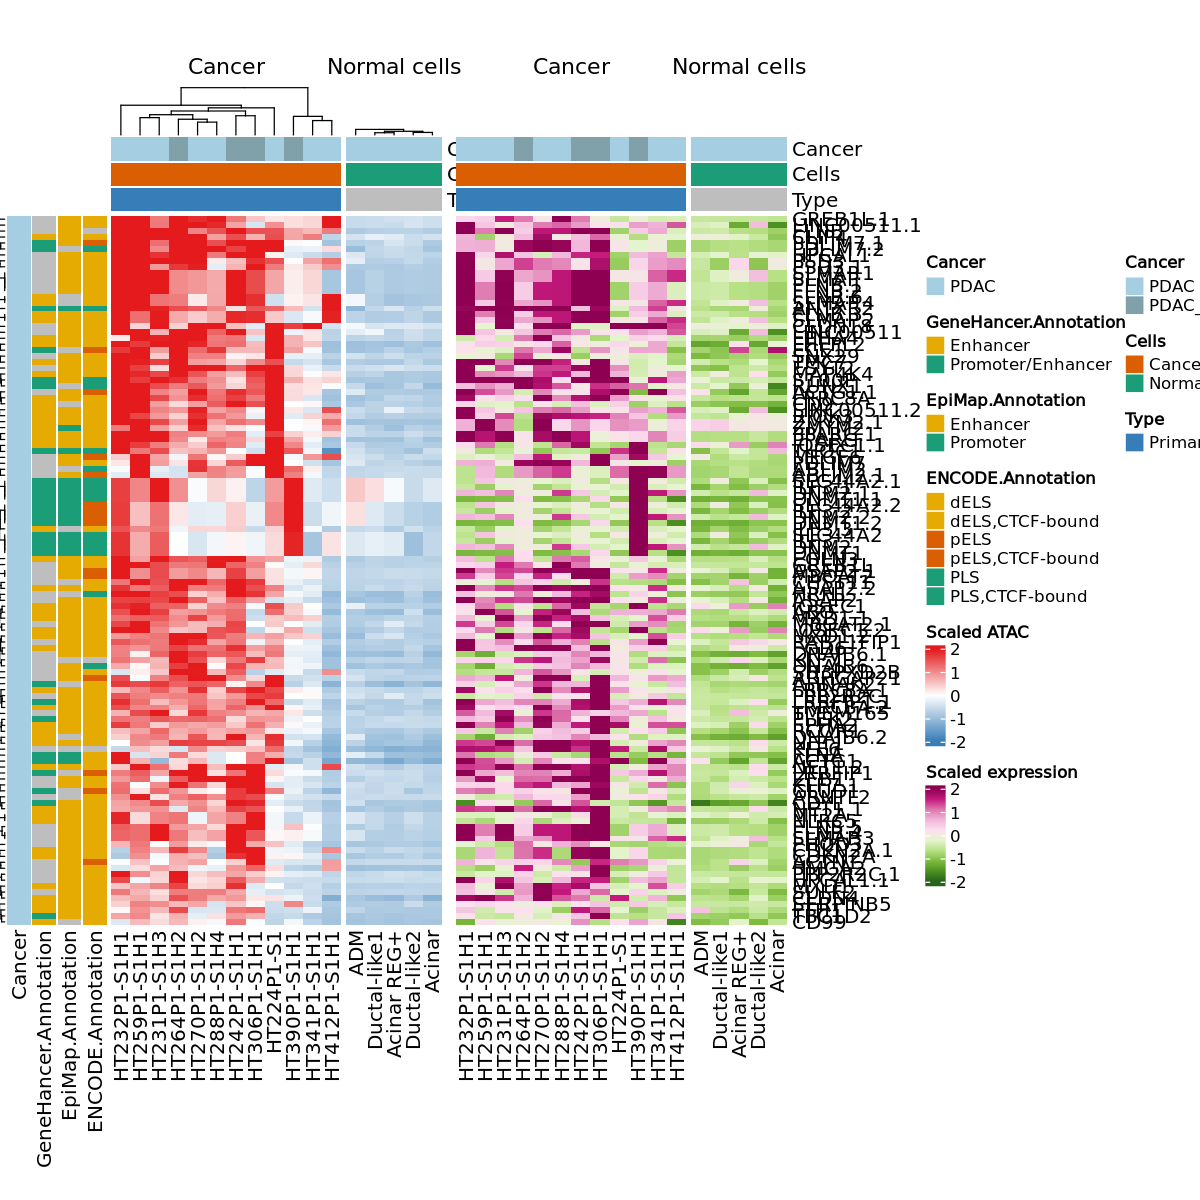

In [16]:
breaks = seq(-2 , 2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(rev(brewer.pal(10, "PiYG")))(length(breaks)))

#toplot.rna.order <- toplot.rna[row_order(p),column_order(p)]
toplot.rna.order <- toplot.rna[,as.numeric(unlist(column_order(p)))]
meta.order <- meta[as.numeric(unlist(column_order(p))),]

column_ha = HeatmapAnnotation(Cancer = meta.order$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.rna.order)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                               Type = meta.order$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)
options(repr.plot.width=10, repr.plot.height=10)

col.split <- case_when(is.na(meta.order$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

row.name <- str_split_fixed(rownames(toplot.rna.order), '[.]', 2)[,1]

colnames(toplot.rna.order) <- str_split_fixed(colnames(toplot.rna.order), '__', 5)[,3]

p2 <- Heatmap(toplot.rna.order, name = "Scaled expression", 
              col = color.palette,cluster_rows = F, cluster_columns = F, 
              show_row_names = T,
             show_column_names = T, 
             top_annotation = column_ha,
              #right_annotation = label_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
           column_split = col.split, 
             width = unit(7, "cm"), height = unit(15, "cm"))



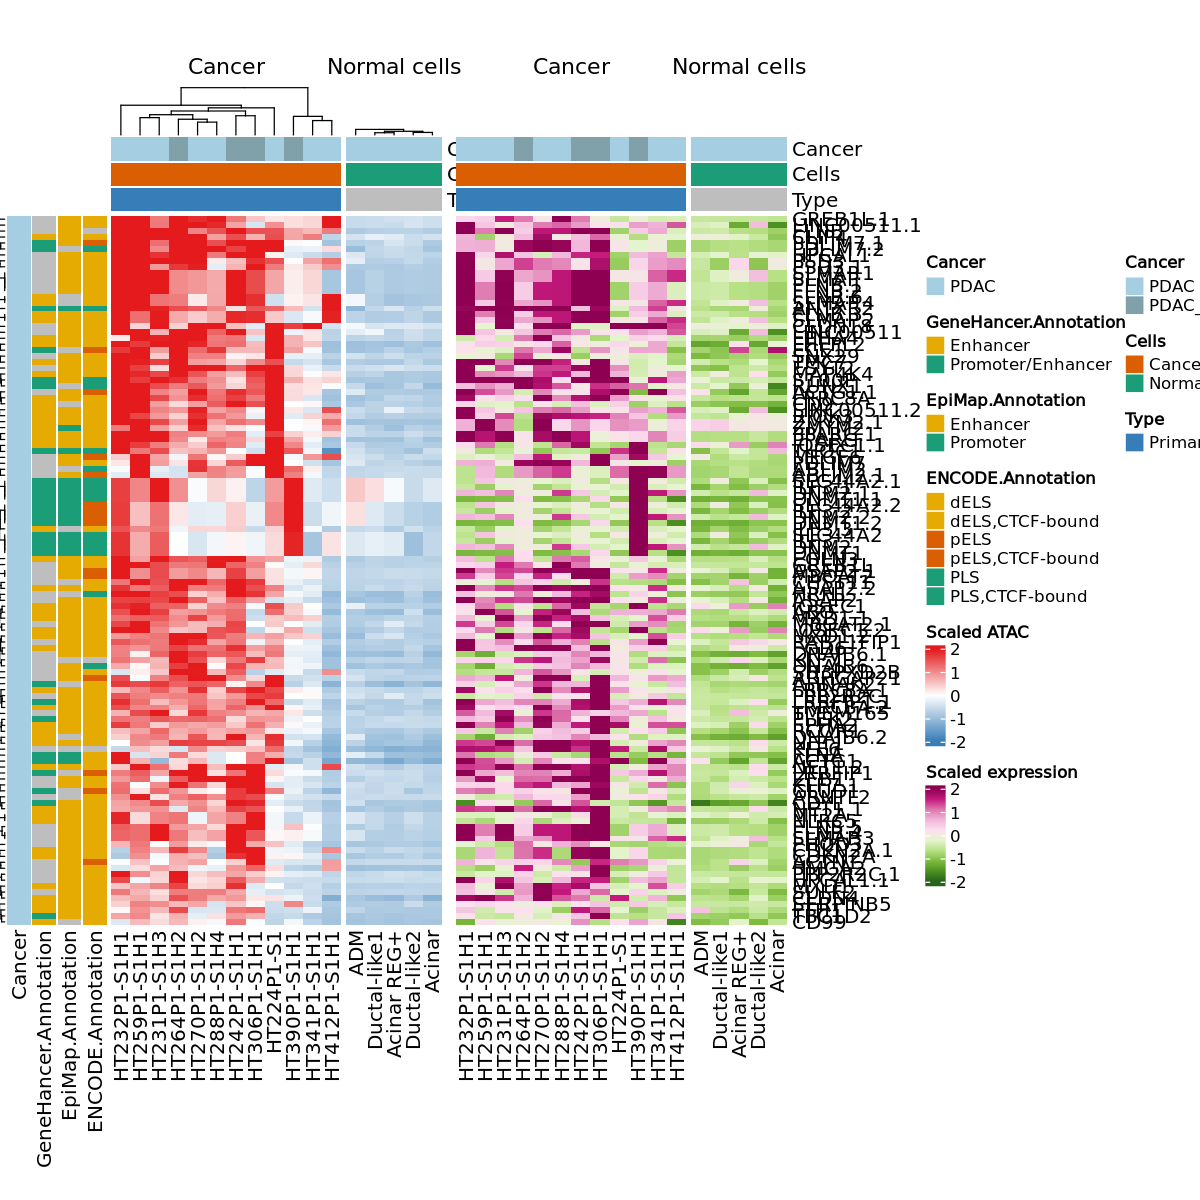

In [17]:
#Panel 3d
p + p2

# BRCA heatmap

In [18]:
cancer.type = 'BRCA'
features <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) %>%
    dplyr::select(Cancer, peak, gene, ends_with('Annotation')) %>%
    distinct()  
dim(features)
head(features)

[1] 242   6

Cancer,peak,gene,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BRCA,chr15-89087977-89088477,ABHD2,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"
BRCA,chr17-81329414-81329914,ACTG1,Enhancer,Enhancer,"pELS,CTCF-bound"
BRCA,chr17-81346014-81346514,ACTG1,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
BRCA,chr17-81514538-81515038,ACTG1,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
BRCA,chr17-81860457-81860957,ACTG1,Promoter/Enhancer,Promoter,
BRCA,chr17-81891409-81891909,ACTG1,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"


In [ ]:
#Table S3 PDAC tab
tosave <- (all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type))
fwrite(tosave, 
     glue::glue('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Suppl.tables/resubmission/Links_{cancer.type}_figure3d.tsv'), sep='\t')



In [19]:
row.anno <- features %>%
    dplyr::select(-gene) %>%
    filter(!duplicated(peak)) %>% 
    data.frame(row.names = 'peak')

head(row.anno[features$peak,])

,Cancer,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
,<chr>,<chr>,<chr>,<chr>
chr15-89087977-89088477,BRCA,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"
chr17-81329414-81329914,BRCA,Enhancer,Enhancer,"pELS,CTCF-bound"
chr17-81346014-81346514,BRCA,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
chr17-81514538-81515038,BRCA,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
chr17-81860457-81860957,BRCA,Promoter/Enhancer,Promoter,
chr17-81891409-81891909,BRCA,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"


In [20]:
#Fetch ATAC and RNA expression data from the averaged object
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'pancan'
toplot.atac <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$peak), slot = 'scale.data')
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'SCT'
toplot.rna <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$gene), slot = 'scale.data')

toplot.atac <- toplot.atac[,features$peak] %>% t
toplot.rna <- toplot.rna[,features$gene] %>% t

toplot.atac <- toplot.atac[,!grepl('oublet', colnames(toplot.atac))]
toplot.rna <- toplot.rna[,!grepl('oublet', colnames(toplot.rna))]

dim(toplot.rna)

meta <- combo.pancan.aver.Piece.normal@meta.data %>% filter(!grepl('oublet', rownames(.)))
meta <- meta %>% filter(Cancer == cancer.type & (Sample_type2=='Primary' | is.na(Sample_type2)))
toplot.atac <- toplot.atac[,rownames(meta)]
toplot.rna <- toplot.rna[,rownames(meta)]



[1] 242 142

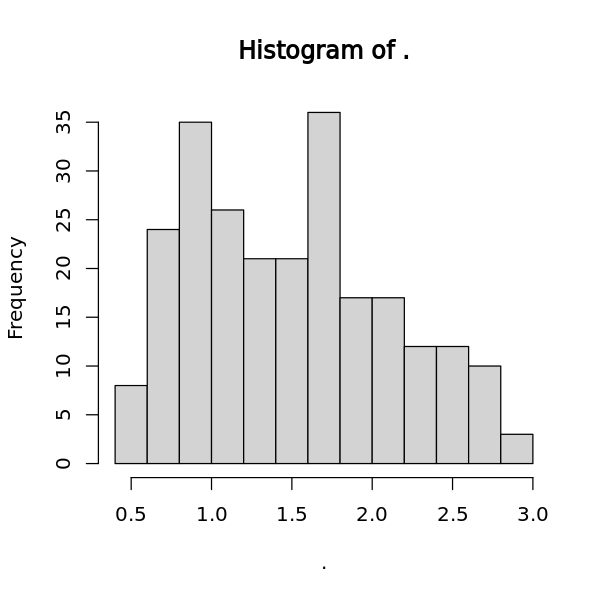

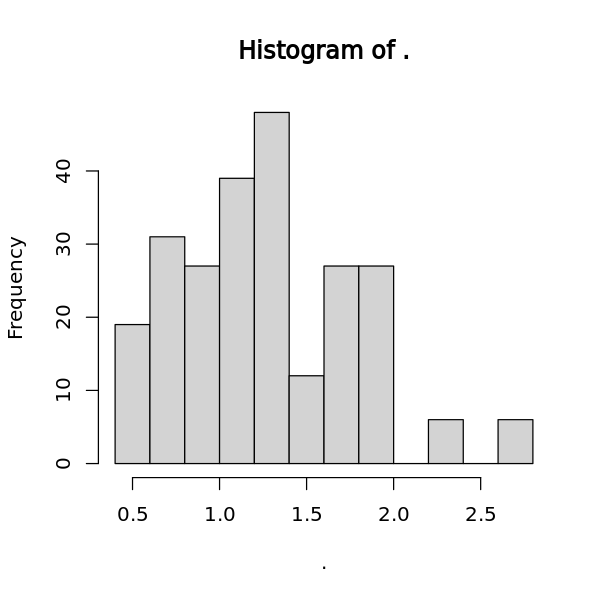

In [21]:

atac.sd <- sapply(rownames(toplot.atac), function(x){
    sd(t(toplot.atac[, grepl('Tumor', colnames(toplot.atac))])[,x])
})

rna.sd <- sapply(rownames(toplot.rna), function(x){
    sd(t(toplot.rna[, grepl('Tumor', colnames(toplot.rna))])[,x])
}) 

options(repr.plot.width=5, repr.plot.height=5)

atac.sd %>% hist
rna.sd %>% hist

if(cancer.type %in% c('PDAC')) {
    toplot.atac <- toplot.atac[atac.sd<2 & rna.sd<1.9,]
    toplot.rna <- toplot.rna[atac.sd<2 & rna.sd<1.9,]

}

In [22]:
breaks = seq(-2 ,2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(c( '#377eb8','white','#e41a1c'))(length(breaks)))

column_ha = HeatmapAnnotation(Cancer = meta$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.atac)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                              Type = meta$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)

row_ha = rowAnnotation(df = row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , ],
                      col = list(Cancer = colors,
                          GeneHancer.Annotation = c('Promoter/Enhancer' = '#1b9e77',
                                                           'Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                EpiMap.Annotation = c('Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                ENCODE.Annotation = c('PLS' = '#1b9e77',
                                                      'PLS,CTCF-bound' = '#1b9e77',
                                                      'dELS' = '#e6ab02',
                                                      'dELS,CTCF-bound' = '#e6ab02',
                                                      'pELS' = '#d95f02',
                                                      'pELS,CTCF-bound' = '#d95f02',
                                                     'CTCF-only,CTCF-bound' = '#7570b3',
                                                     'DNase-H3K4me3' = '#a6761d',
                                                     'DNase-H3K4me3,CTCF-bound' = '#a6761d')
                                )
                      )


col.split <- case_when(is.na(meta$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

#row.split <- row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , 'Cancer']

colnames(toplot.atac) <- str_split_fixed(colnames(toplot.atac), '__', 5)[,3]

options(repr.plot.width=10, repr.plot.height=10)
p <- Heatmap(toplot.atac, name = "Scaled ATAC", cluster_column_slices = F,
             col = color.palette,cluster_rows = T, show_row_names = F,
             show_column_names = T, 
             top_annotation = column_ha,
             left_annotation = row_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
            column_split = col.split, 
             #row_split = row.split,
             width = unit(7, "cm"), height = unit(15, "cm"))

breaks = seq(-2 , 2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(rev(brewer.pal(10, "PiYG")))(length(breaks)))

#toplot.rna.order <- toplot.rna[row_order(p),column_order(p)]
toplot.rna.order <- toplot.rna[,as.numeric(unlist(column_order(p)))]
meta.order <- meta[as.numeric(unlist(column_order(p))),]

column_ha = HeatmapAnnotation(Cancer = meta.order$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.rna.order)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                               Type = meta.order$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)
options(repr.plot.width=10, repr.plot.height=10)

col.split <- case_when(is.na(meta.order$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

row.name <- str_split_fixed(rownames(toplot.rna.order), '[.]', 2)[,1]

colnames(toplot.rna.order) <- str_split_fixed(colnames(toplot.rna.order), '__', 5)[,3]

p2 <- Heatmap(toplot.rna.order, name = "Scaled expression", 
              col = color.palette,cluster_rows = F, cluster_columns = F, 
              show_row_names = T,
             show_column_names = T, 
             top_annotation = column_ha,
              #right_annotation = label_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
           column_split = col.split, 
             width = unit(7, "cm"), height = unit(15, "cm"))




Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


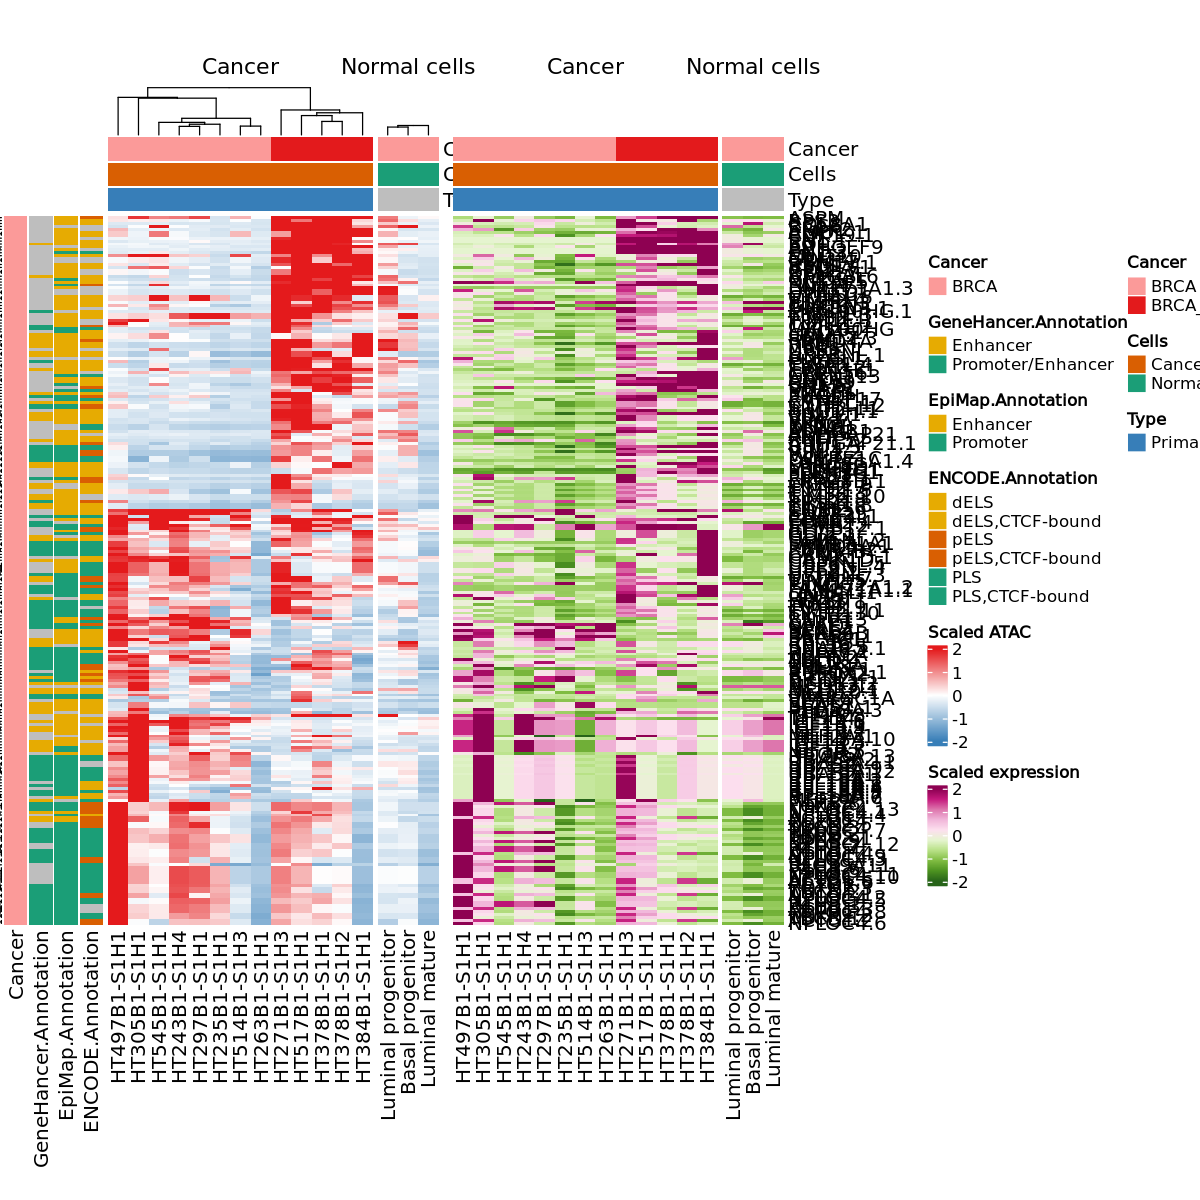

In [23]:
#Panel S6e
p + p2

# Make coverage plots

In [5]:
#some functions
get.plotting.region <- function(tb, gene.l, padding=0) {
    tb <- tb %>% filter(gene==gene.l)
    con.starts <- tb %>% pull(start) %>% as.numeric()
    con.ends <- tb %>% pull(end) %>% as.numeric()
    chrom <- tb$seqnames[1]
    
    region <- paste(chrom, 
                    min(c(con.starts, con.ends))-padding,
                    max(c(con.starts, con.ends))+padding,
            sep = '-')
    
    return (region %>% StringToGRanges())
} 

get.enhancer.location <- function(interesting.enhancers, gene.l) {
    #print(interesting.enhancers %>% filter(gene==gene))
    enh.tb <- interesting.enhancers %>% filter(gene==gene.l & EpiMap.Annotation!="")
    #print(dim(enh.tb))
    enh.tb.enhancer <- enh.tb %>% filter(EpiMap.Annotation=='Enhancer')
    enh.tb.promoter <- enh.tb %>% filter(EpiMap.Annotation!='Enhancer')

    if(nrow(enh.tb.enhancer)>0) {
        enh <- enh.tb.enhancer$EpiMap.Location %>% unique() %>% StringToGRanges()
        enh$color <- '#FFDE17'
        
    } else {
        print('no EpiMap enhancers')
        enh <- NULL
    }
    
    if (nrow(enh.tb.promoter)>0) {
        prom <- enh.tb.promoter$EpiMap.Location %>% unique() %>% StringToGRanges()
        prom$color <- '#1b9e77'
    } else {
        print('no EpiMap promoters')
        prom <- NULL
    }
    if (!is.null(enh) & !is.null(prom)) {
    final.ranges <- c(enh, prom)
    } else if(!is.null(enh)) { 
        final.ranges <- enh
    } else if(!is.null(prom)) { 
        final.ranges <- prom
    } else {
        final.ranges <- NULL
    }
        
    return(final.ranges)
}



linkPlot_from_df <- function(link.df, plot.region, cutoff=0, padding=0) {
    chromosome <- link.df$seqnames[1]
    link.df$group <- seq_len(length.out = nrow(x = link.df))
      link.df <- link.df %>% filter(score>=cutoff)
    df <- data.frame(
      x = c(link.df$start,
            (link.df$start + link.df$end) / 2,
            link.df$end),
      y = c(rep(x = 0, nrow(x = link.df)),
            rep(x = -1, nrow(x = link.df)),
            rep(x = 0, nrow(x = link.df))),
      group = rep(x = link.df$group, 3),
      score = rep(link.df$score, 3),
        Cancer = rep(x = link.df$Cancer, 3))
    
    df <- df %>% mutate(y = case_when(y==-1 ~ -score, TRUE ~ 0))
    lev <- df %>% filter(y<0) %>% arrange(desc(y)) %>% pull(group)
     df$group <- factor(df$group, levels = lev) 
    
    
    p <- ggplot() +
      ggforce::geom_bezier(data = df,
        mapping = aes_string(x = "x", y = "y", group = "group", color = "Cancer")) +
      geom_hline(yintercept = 0, color = 'grey') +
      scale_color_manual(values = colors)
    
    p <- p +
    theme_classic() +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) +
    
    ylab("Links") +
    xlab(label = paste0(chromosome, " position (bp)")) +
    xlim(c(GenomicRanges::start(x = plot.region)-padding, GenomicRanges::end(x = plot.region))+padding)
  return(p)

}




In [6]:
#open object
combo.pancan <- readRDS('/diskmnt/Projects/snATAC_primary/PanCan_ATAC_data_freeze/v7.0/Multiome/Merged_objects_PanCan_peaks/Pancan_level/out/Pancan_all_cells_multiome_obj.20230306.rds')
basal.piece.id <- c("HT268B1-Th1H3", "HT029B1-S1PC", "HT035B1-S1PA",
                 "HT1408-06","HT141B1-S1H1", "HT206B1-S1H4", "HT271B1-S1H3",
                "HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1")
non.squamous.cesc <- c('CE507-C1A2', 'CE354E1-S1', 'CE357E1-S1', 'CE336E1-S1', 'CE332E1-N1')
pdac.basal <- c('HT242P1-S1H1','HT264P1-S1H2', 'HT306P1-S1H1', 'HT390P1-S1H1', 'HT181P1-T1A3', 'HT090P1-T2A3', 
                'HT447P1-Th1K1A3', 'HT452P1-Th1K1', 'PM565P1-T1N1', 'PM1380P1-T1Y2')



normal.meta.pdac <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Normal_cell_typing_detailed/v7.0/PDAC/ATAC/cell_typing/PDAC_ATAC_normal_cell_type_combo_regular.tsv', header = T) %>%
    data.frame(row.names = 1)

normal.meta.crc <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Normal_cell_typing_detailed/v7.0/CRC/ATAC/cell_typing/CRC_ATAC_normal_cell_type_combo_regular.tsv', header = T) %>%
    data.frame(row.names = 1)


combo.pancan <- AddMetaData(combo.pancan, rbind(normal.meta.pdac, normal.meta.crc))
combo.pancan$cell_type.normal <- case_when(is.na(combo.pancan$cell_type.normal) ~ combo.pancan$cell_type.harmonized.cancer.atac,
                                 TRUE ~ combo.pancan$cell_type.normal)


combo.pancan@meta.data <- combo.pancan@meta.data %>% 
    mutate(Cancer.new = case_when((Piece_ID %in% basal.piece.id) & !is.na(Sample_type) ~ 'BRCA_Basal', 
                                  (Piece_ID %in% non.squamous.cesc) & !is.na(Sample_type) ~ 'CESC_Non-squamous',
                                  #(Piece_ID %in% pdac.basal) & !is.na(Sample_type) ~ 'PDAC_Basal',
                                  TRUE ~ Cancer)) %>%
    mutate(Cancer.common = case_when(Cancer.new %in% c('UCEC', 'OV') ~ 'UCEC&OV',
                                  Cancer.new %in% c('CESC', 'HNSCC') ~ 'HNSCC&CESC',
                                  TRUE ~ Cancer)) %>%
    mutate(Sample_type2 = case_when(Sample_type=='Tumor' ~ 'Primary',
                                   TRUE ~ Sample_type)) %>%
    mutate(Cancer_stage_cell_type.normal = case_when(cell_type.normal == 'Tumor' ~ paste(Cancer.new,Sample_type2, 'Cancer', cell_type.normal, sep='__' ),
               TRUE ~ paste(Cancer, 'Normal',cell_type.normal, sep='__')))  %>%
    mutate(Cancer_Piece_cell_type.normal = case_when(cell_type.normal == 'Tumor' ~ paste(Cancer,Sample_type2, Piece_ID, 'Cancer', cell_type.normal, sep='__' ),
               TRUE ~ paste(Cancer, 'Normal',cell_type.normal, sep='__')))  %>%
    mutate(Cancer_cell_type.normal = case_when(cell_type.normal == 'Tumor' ~ paste(Cancer.new, 'Cancer cells', sep='__' ),
           TRUE ~ paste(Cancer, 'Normal',cell_type.normal, sep='__')))




[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr2 9066222-9292801      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "PDAC__Primary__Cancer__Tumor" "PDAC__Normal__Ductal-like2"

Warning message:
“Removed 62 rows containing missing values (`geom_segment()`).”


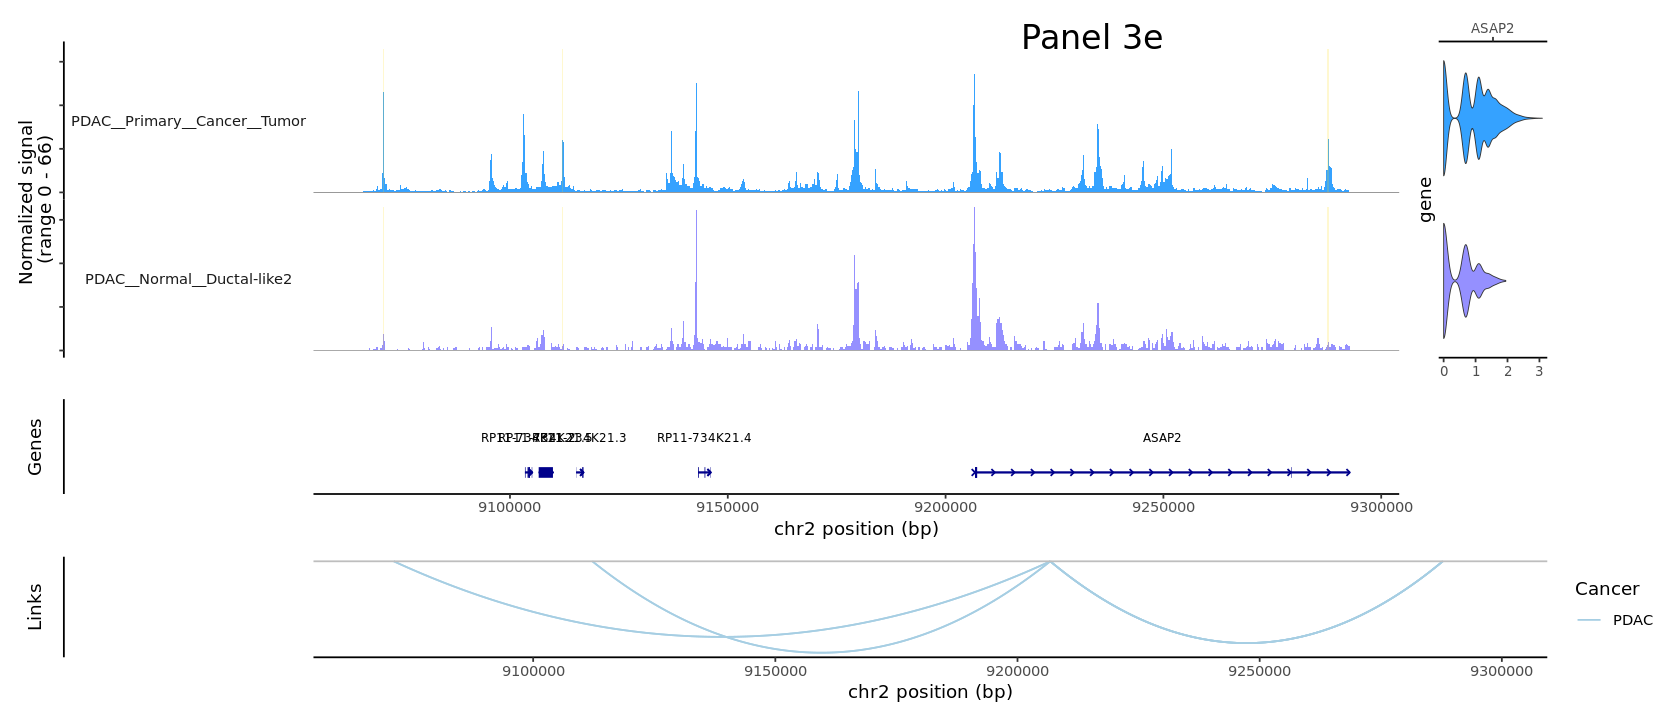

In [27]:
normal.cells <- list('CRC' = 'Stem|stem',
                    HNSCC = 'Normal squa', CESC = 'Normal squa',
                    BRCA = 'mature|Luminal pro', PDAC='like2', 
                    UCEC = 'Secretory', OV = 'Secretory', SKCM='Melano')


DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'PDAC'
gene.oi = 'ASAP2'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel 3e", x = 0.65, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]     chr3 12225034-12450263      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "PDAC__Primary__Cancer__Tumor" "PDAC__Normal__Ductal-like2"

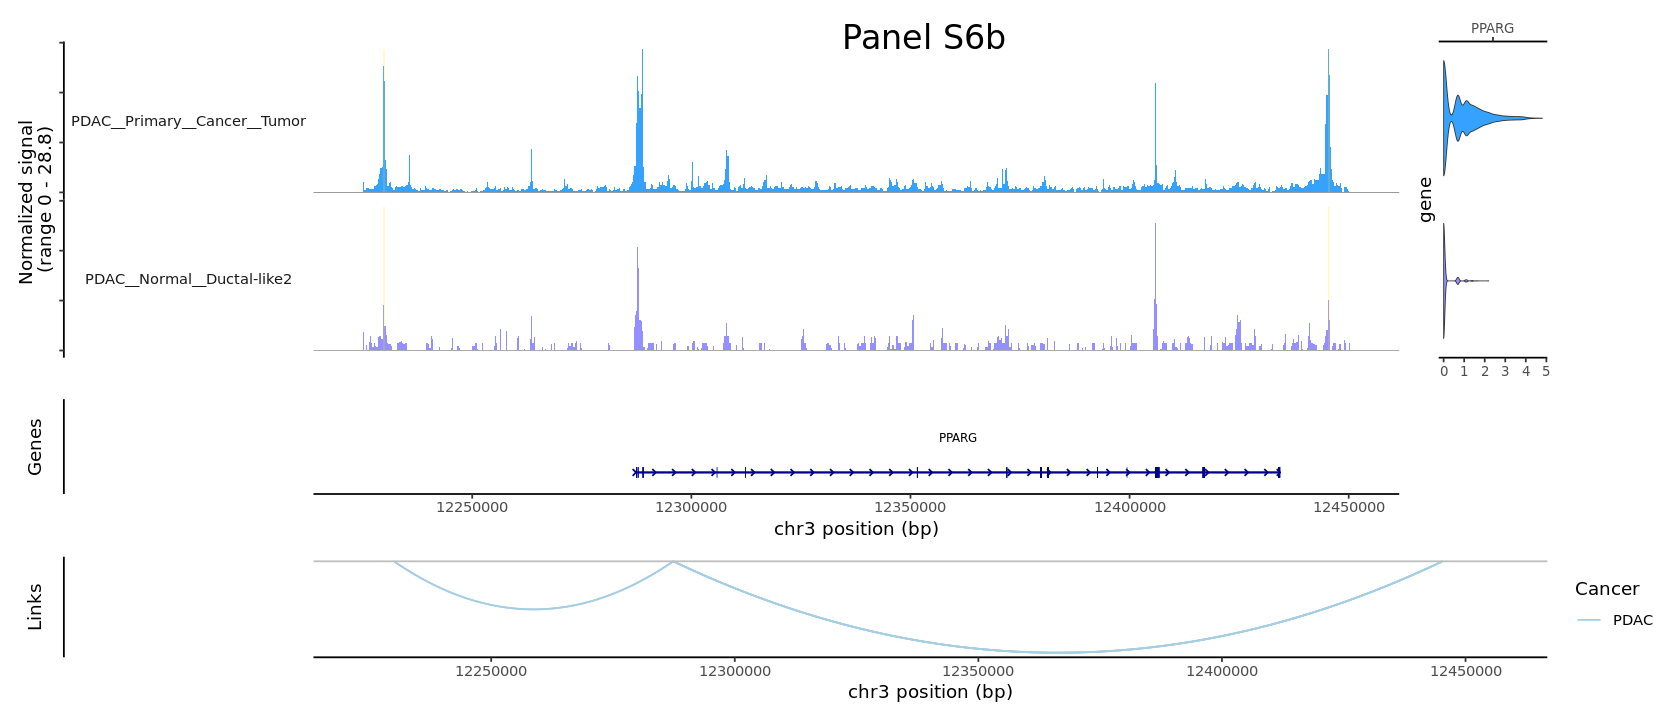

In [28]:
DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'PDAC'
gene.oi = 'PPARG'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel S6b", x = 0.55, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]     chr3 57954092-58013400      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "PDAC__Primary__Cancer__Tumor" "PDAC__Normal__Ductal-like2"

Warning message:
“Removed 267 rows containing missing values (`geom_segment()`).”


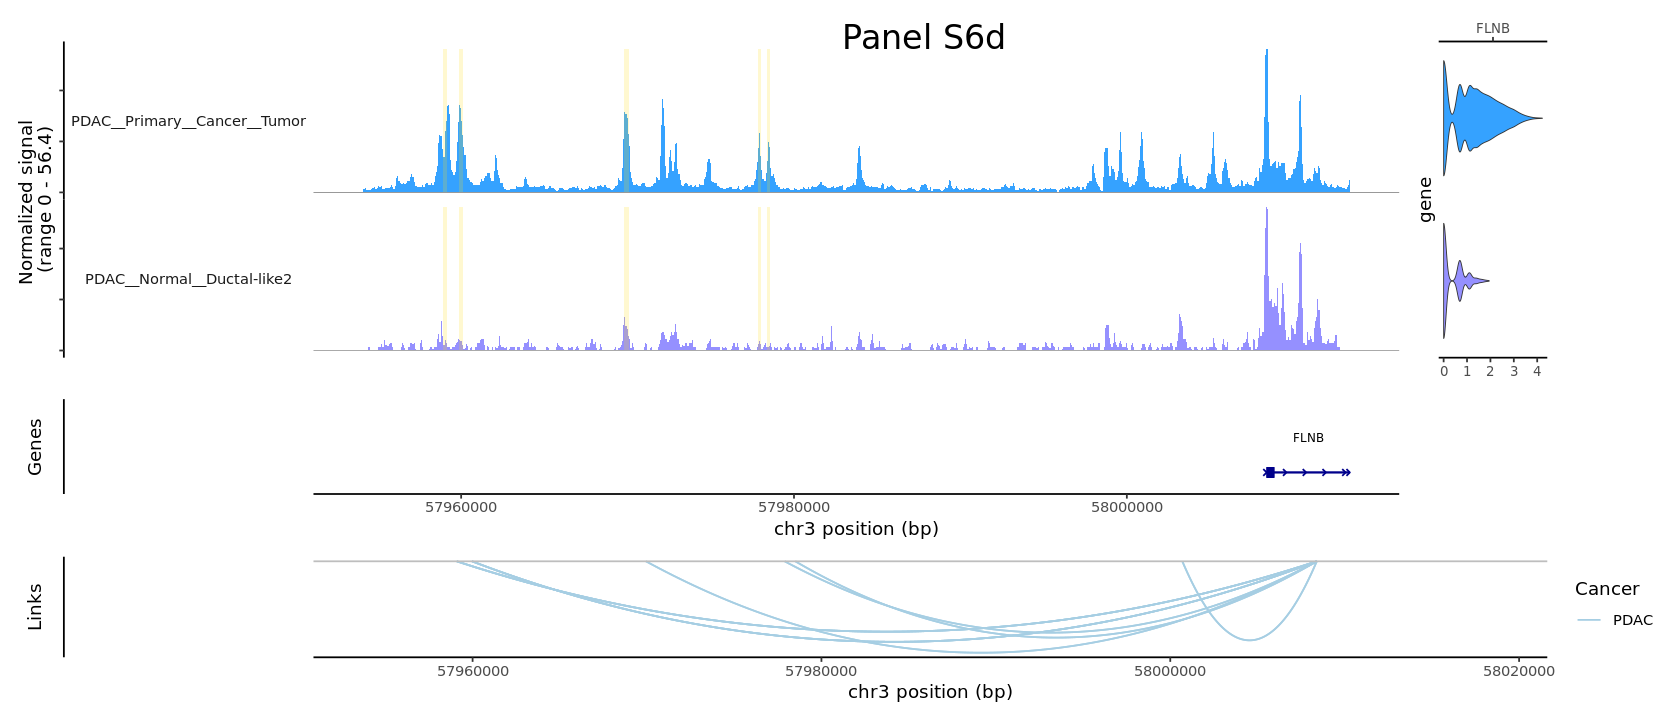

In [29]:
DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'PDAC'
gene.oi = 'FLNB'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel S6d", x = 0.55, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]     chr6 43690849-43884194      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "BRCA__Normal__Luminal mature"       "BRCA__Normal__Luminal progenitor"  
[3] "BRCA_Basal__Primary__Cancer__Tumor"

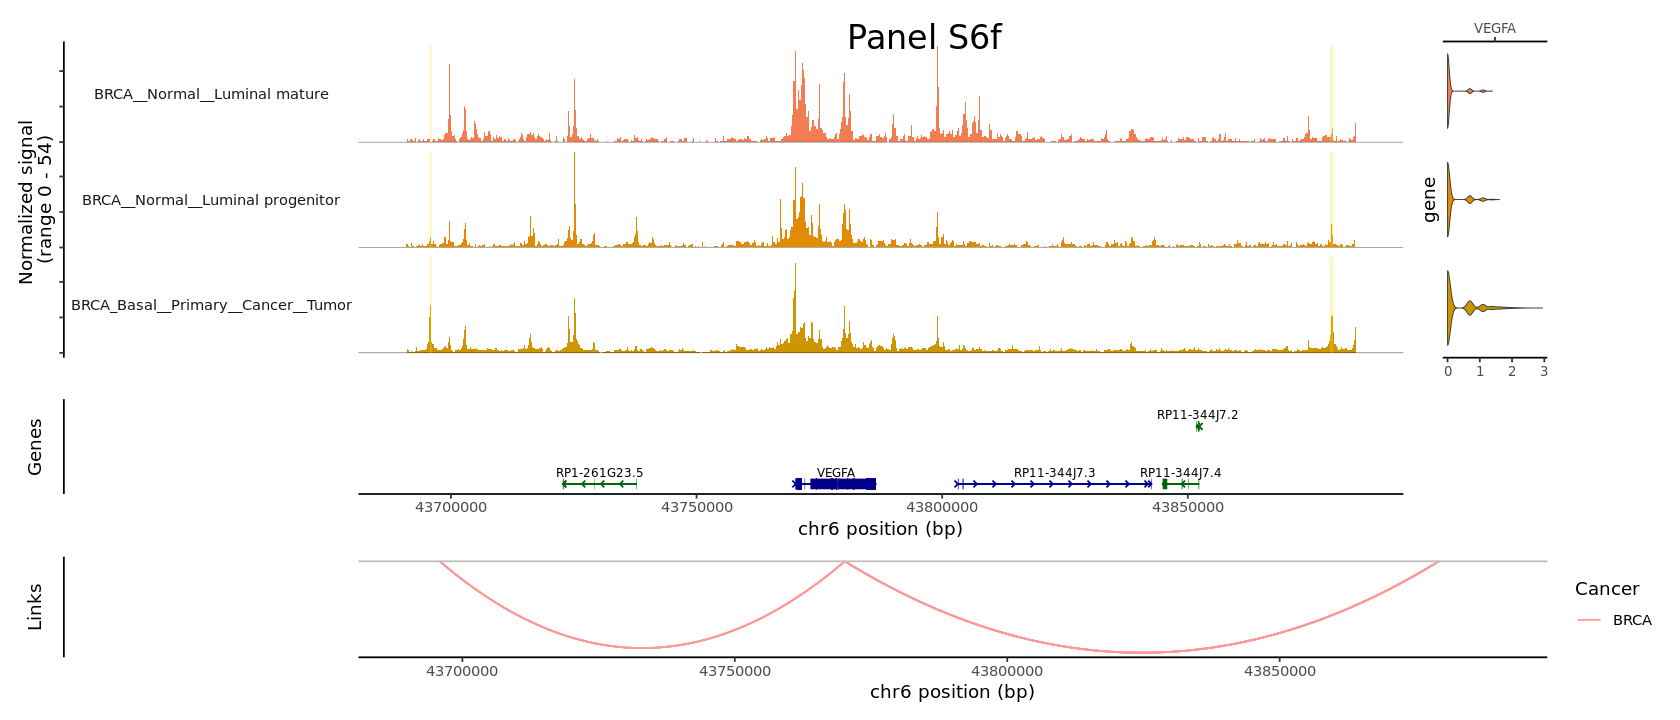

In [30]:
DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'BRCA'
gene.oi = 'VEGFA'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow) & grepl('_Basal',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel S6f", x = 0.55, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

GRanges object with 1 range and 0 metadata columns:
      seqnames              ranges strand
         <Rle>           <IRanges>  <Rle>
  [1]     chr2 118818202-118860827      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "BRCA__Normal__Luminal mature"       "BRCA__Normal__Luminal progenitor"  
[3] "BRCA_Basal__Primary__Cancer__Tumor"

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


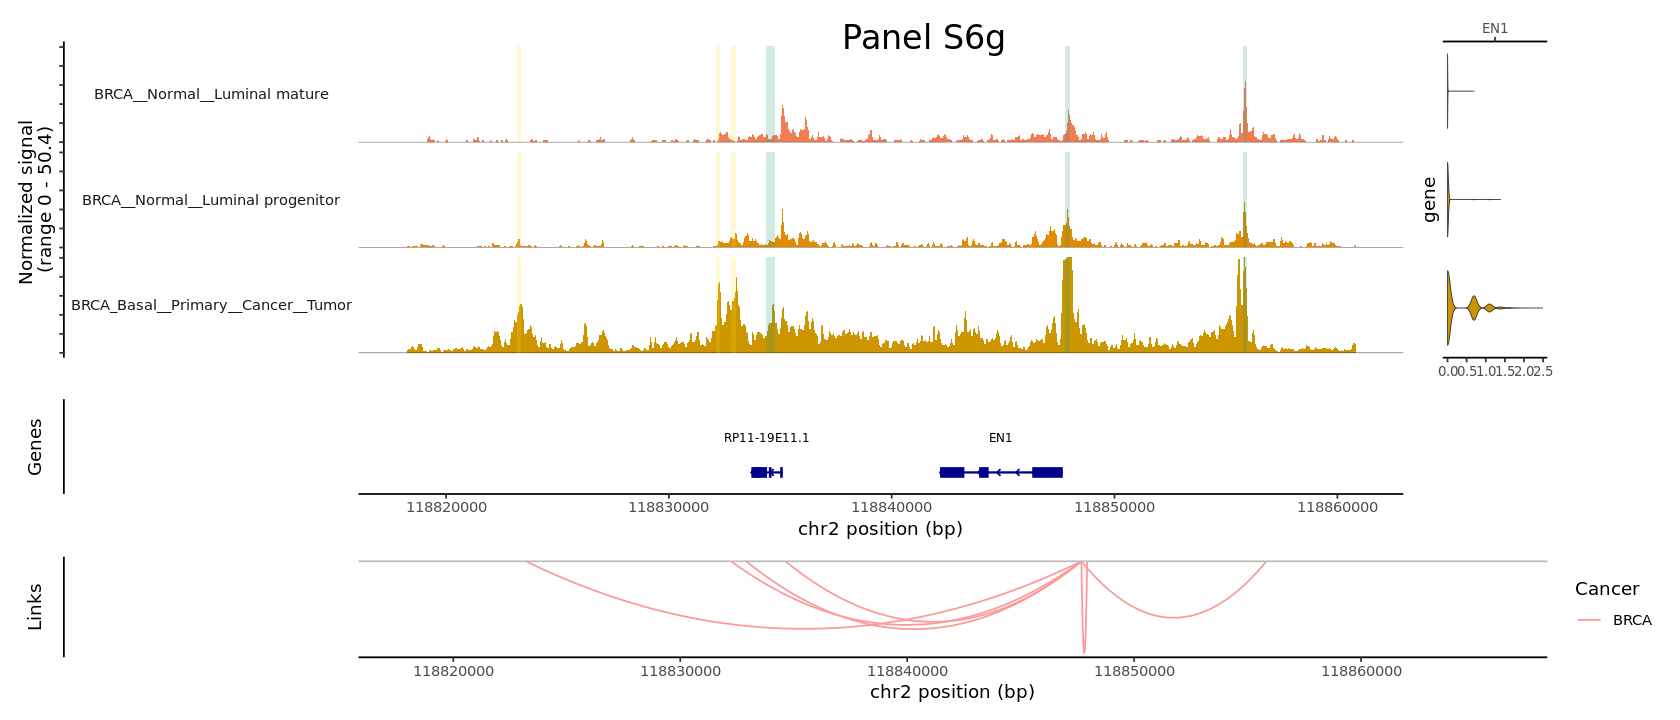

In [9]:
DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'BRCA'
gene.oi = 'EN1'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow) & grepl('_Basal',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel S6g", x = 0.55, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it